In [1]:
import sys
import numpy as np
from matplotlib import pyplot as plt
from skimage.filters import gaussian
from keras.models import load_model
from keras.datasets import mnist
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
sas_raw = np.fromfile('raw_explanations.npy').reshape(10000, 28, 28)
sas_ft = np.fromfile('ft20_explanations.npy').reshape(10000, 28, 28)
gradcam = np.fromfile('gradcam.npy').reshape(10000, 28, 28)
guided_backprop = np.fromfile('guided_backprop.npy').reshape(10000, 28, 28)
guided_gradcam = np.fromfile('guided_gradcam.npy').reshape(10000, 28, 28)

Loading MNIST
0.8 1.0


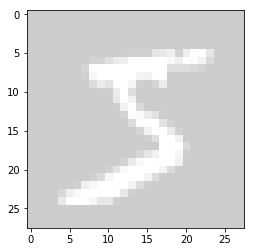

Test accuracy: 0.982399731874


In [3]:
def load_mnist():
    print('Loading MNIST')
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = np.expand_dims(x_train, -1) / 255 / 5 + 4 / 5
    x_test = np.expand_dims(x_test, -1) / 255 / 5 + 4 / 5
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)
    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_mnist()
print(x_train.min(), x_train.max())
plt.imshow(x_train[0, :, :, 0], vmin=0, vmax=1, cmap='gray')
plt.show()
model = load_model('classifier.hdf5')
ev = model.evaluate(x_test, y_test, batch_size=5000, verbose=False)
print('Test accuracy:', ev[1])

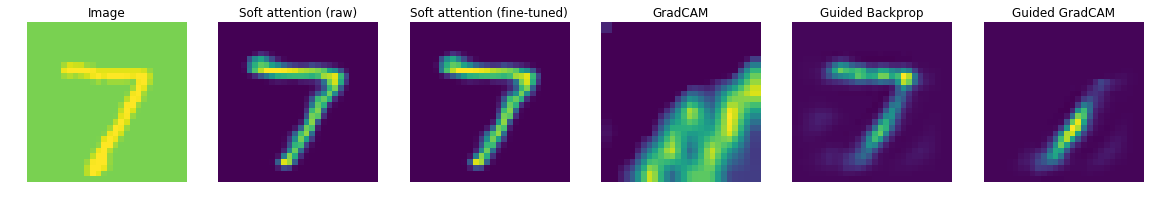

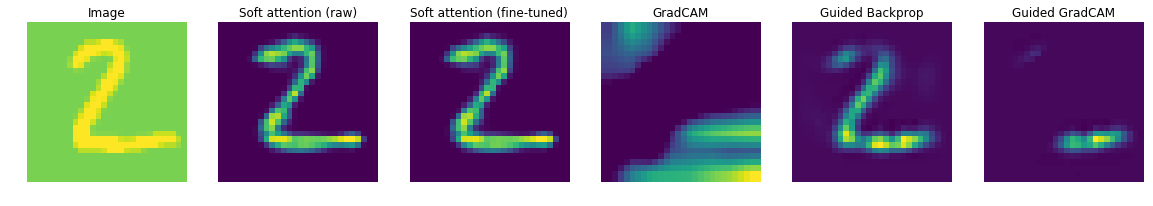

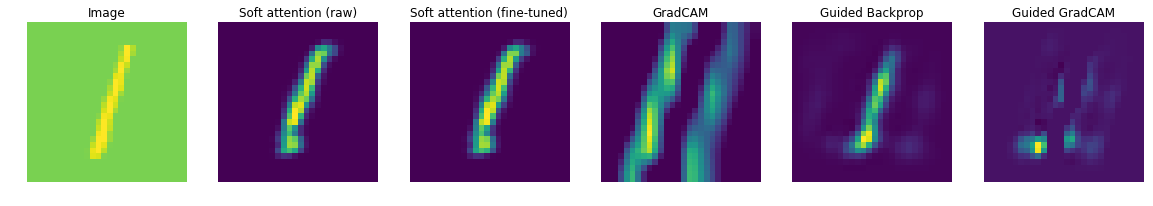

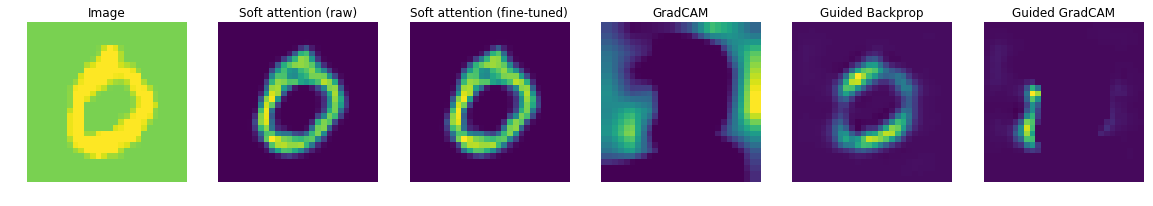

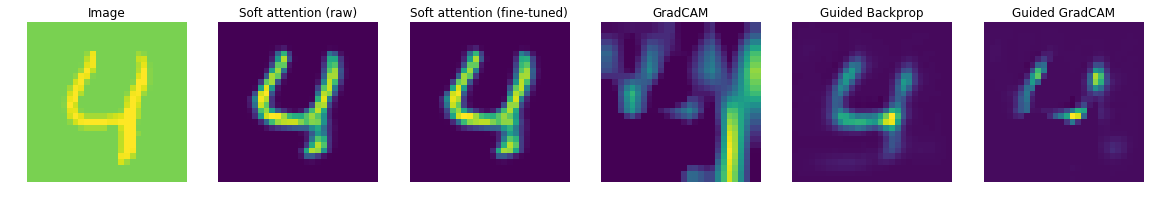

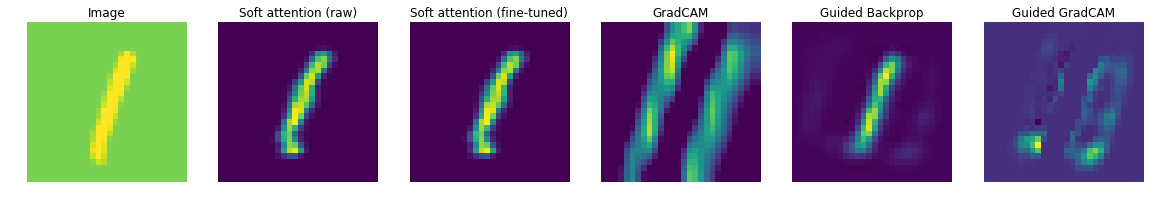

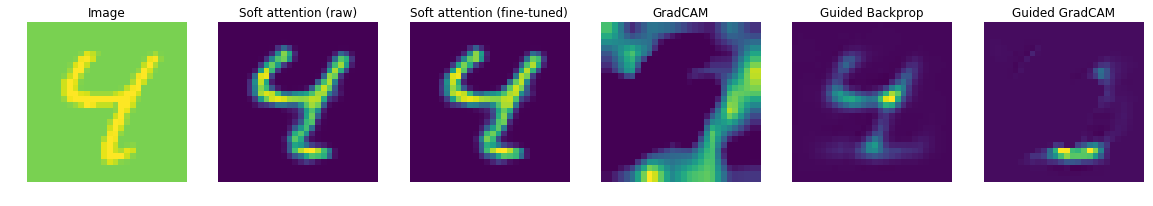

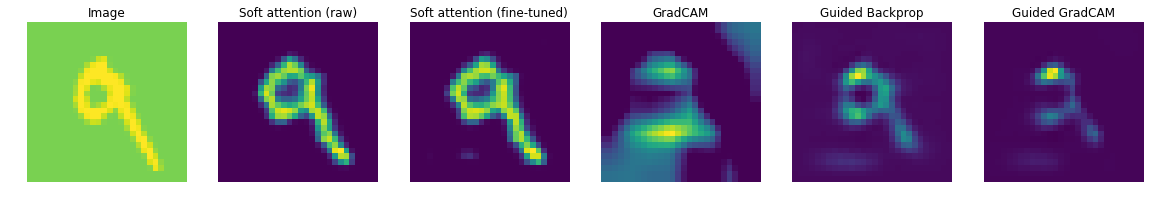

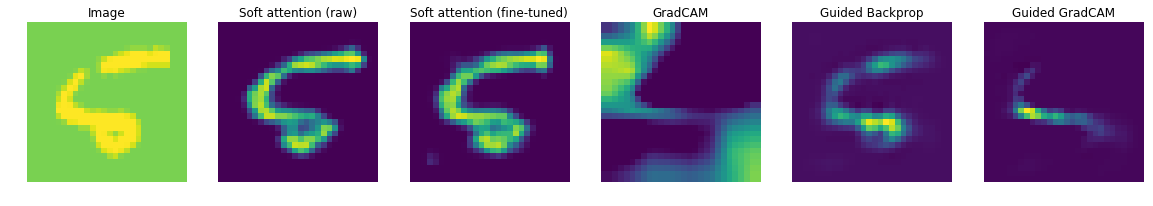

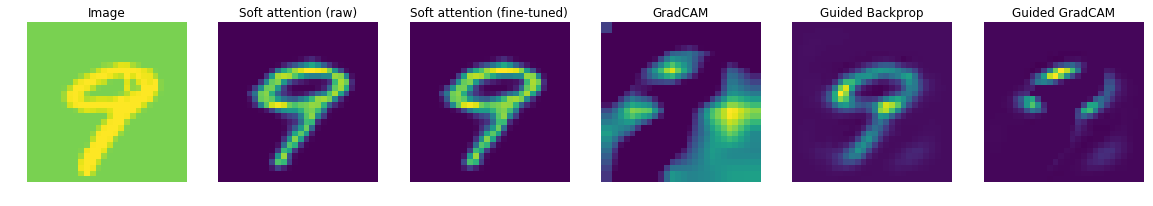

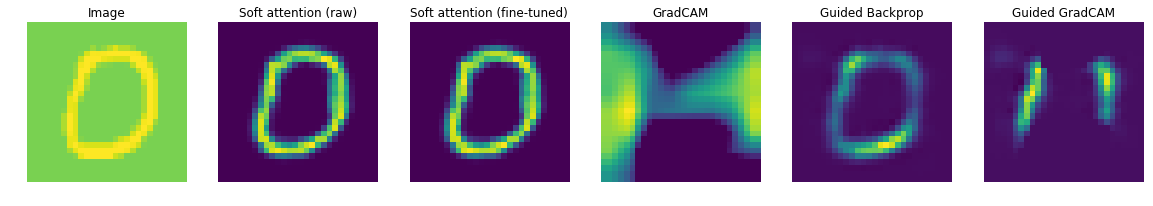

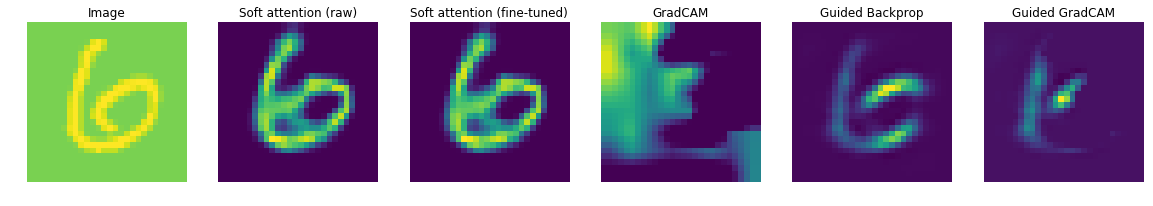

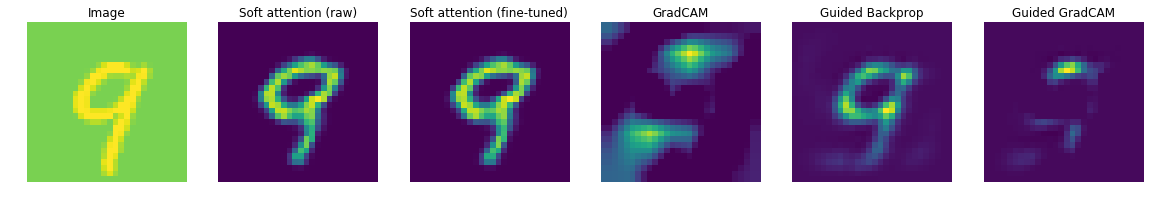

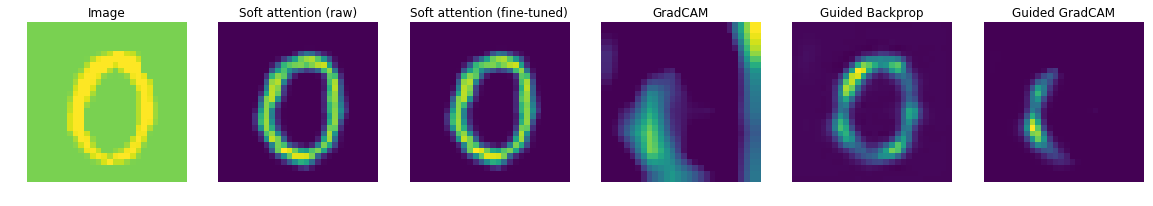

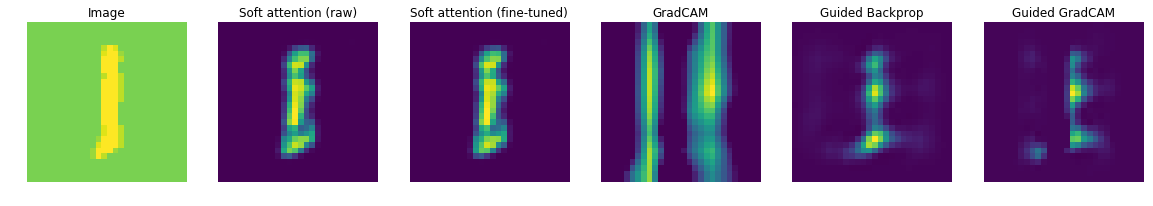

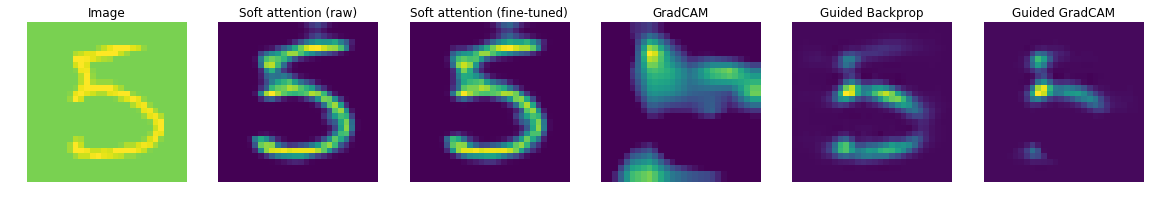

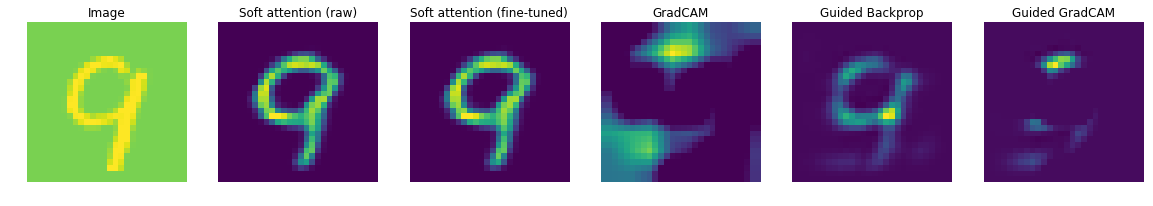

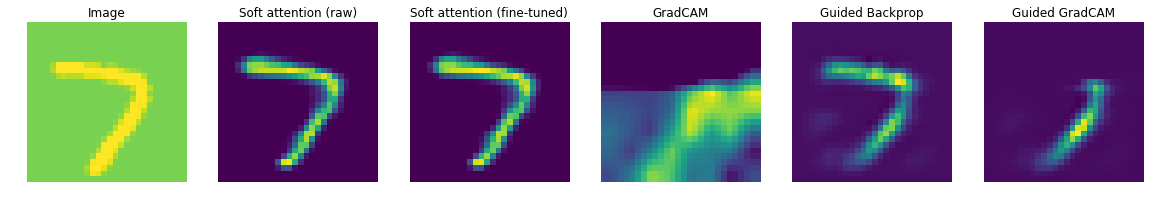

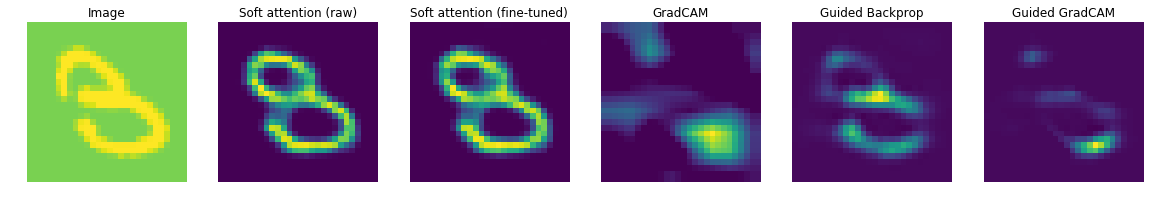

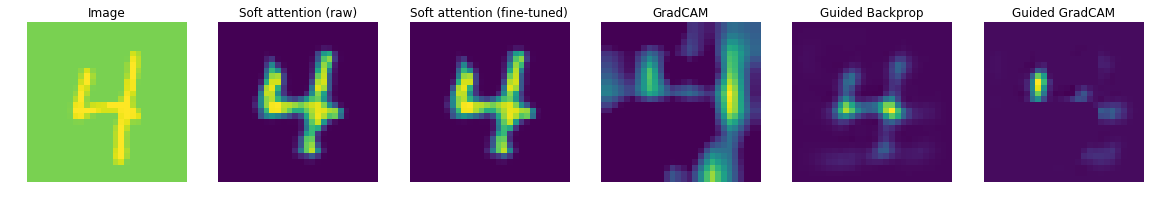

In [4]:
for i in range(20):
    plt.figure(figsize=(20, 5))
    
    plt.subplot(161)
    plt.title('Image')
    plt.axis('off')
    plt.imshow(x_test[i, :, :, 0], vmin=0, vmax=1)
    
    plt.subplot(162)
    plt.title('Soft attention (raw)')
    plt.axis('off')
    plt.imshow(sas_raw[i])
    
    plt.subplot(163)
    plt.title('Soft attention (fine-tuned)')
    plt.axis('off')
    plt.imshow(sas_ft[i])
    
    plt.subplot(164)
    plt.title('GradCAM')
    plt.axis('off')
    plt.imshow(gradcam[i], vmin=0, vmax=1)
    
    plt.subplot(165)
    plt.title('Guided Backprop')
    plt.axis('off')
    plt.imshow(guided_backprop[i])
    
    plt.subplot(166)
    plt.title('Guided GradCAM')
    plt.axis('off')
    plt.imshow(guided_gradcam[i])
    plt.show()

In [5]:
# Flip N pixels at a time, no reevaluation
def explanation_selectivity(imgs, explanations, N, blur=False):
    imgs_copy = imgs.copy()
    if blur:
        explanations = explanations.copy()
        for i in range(explanations.shape[0]):
            explanations[i] = gaussian(explanations[i])
        print('Blurring done')
    
    predictions = model.predict(imgs_copy)
    top = np.argmax(predictions, -1)
    n_steps = (28 * 28 + N - 1) // N
    hist = np.empty((n_steps + 1, imgs.shape[0]))
    hist[0] = predictions[range(10000), top]    
    painting_order = np.flip(np.argsort(explanations.reshape(-1, 28*28), axis=1), axis=-1)    
    
    r = np.array(range(10000)).reshape(10000, 1)
    plt.ion()
    # While not all pixels are black
    for step in range(n_steps):
        sys.stdout.write('\r')
        sys.stdout.write("[%-20s] %.0f%%" % ('='*int(step/n_steps * 20), 100*step/n_steps))
        sys.stdout.flush()        
        coords = painting_order[:, N * step:N * (step + 1)]
        imgs_copy.reshape(10000, -1)[r, coords] = 0
        hist[step + 1] = model.predict(imgs_copy, batch_size=5000)[range(10000), top]
    sys.stdout.write('\r')
    sys.stdout.flush()
    print("[%-20s] %.0f%%" % ('='*20, 100))
    return hist

def auc(arr):
    return (arr.sum() - arr[0] / 2 - arr[-1] / 2) / (arr.shape[0] - 1)

In [6]:
hist_sas_raw = explanation_selectivity(x_test, sas_raw, N=7)
hist_sas_ft = explanation_selectivity(x_test, sas_ft, N=7)
hist_gradcam = explanation_selectivity(x_test, gradcam, N=7)
hist_guided_backprop = explanation_selectivity(x_test, guided_backprop, N=7)
hist_guided_gradcam = explanation_selectivity(x_test, guided_gradcam, N=7)
hist_selfsal = explanation_selectivity(x_test, x_test, N=7)

[====================] 100%
[====================] 100%
[====================] 100%
[====================] 100%
[====================] 100%
[====================] 100%


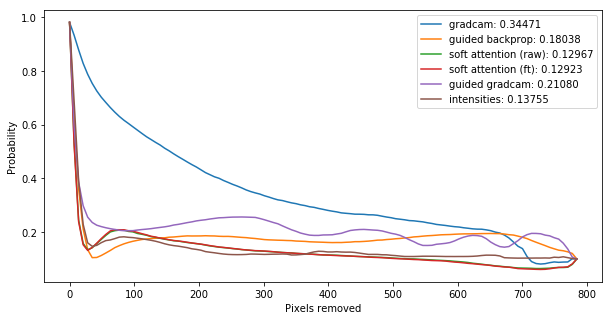

In [7]:
plt.figure(figsize=(10, 5))

n_steps = hist_gradcam.shape[0]
N = 7
plt.plot(N*np.arange(n_steps), hist_gradcam.mean(1))
plt.plot(N*np.arange(n_steps), hist_guided_backprop.mean(1))
plt.plot(N*np.arange(n_steps), hist_sas_raw.mean(1))
plt.plot(N*np.arange(n_steps), hist_sas_ft.mean(1))
plt.plot(N*np.arange(n_steps), hist_guided_gradcam.mean(1))
plt.plot(N*np.arange(n_steps), hist_selfsal.mean(1))

plt.legend(['gradcam: {:.5f}'.format(auc(hist_gradcam.mean(1))), 
            'guided backprop: {:.5f}'.format(auc(hist_guided_backprop.mean(1))), 
            'soft attention (raw): {:.5f}'.format(auc(hist_sas_raw.mean(1))), 
            'soft attention (ft): {:.5f}'.format(auc(hist_sas_ft.mean(1))), 
            'guided gradcam: {:.5f}'.format(auc(hist_guided_gradcam.mean(1))), 
            'intensities: {:.5f}'.format(auc(hist_selfsal.mean(1)))])
plt.xlabel('Pixels removed')
plt.ylabel('Probability')
plt.show()

### With gaussian blur applied to the saliency

In [8]:
hist_sas_raw_blur = explanation_selectivity(x_test, sas_raw, N=7, blur=True)
hist_sas_ft_blur = explanation_selectivity(x_test, sas_ft, N=7, blur=True)
hist_gradcam_blur = explanation_selectivity(x_test, gradcam, N=7, blur=True)
hist_guided_backprop_blur = explanation_selectivity(x_test, guided_backprop, N=7, blur=True)
hist_guided_gradcam_blur = explanation_selectivity(x_test, guided_gradcam, N=7, blur=True)
hist_selfsal_blur = explanation_selectivity(x_test, x_test, N=7, blur=True)

Blurring done
[====================] 100%
Blurring done
[====================] 100%
Blurring done
[====================] 100%
Blurring done
[====================] 100%
Blurring done
[====================] 100%
Blurring done
[====================] 100%


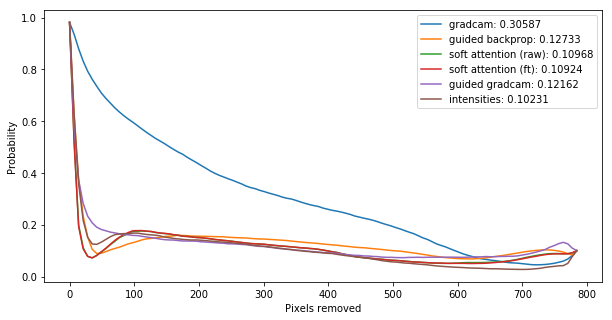

In [10]:
plt.figure(figsize=(10, 5))

n_steps = hist_gradcam_blur.shape[0]
N = 7
plt.plot(N*np.arange(n_steps), hist_gradcam_blur.mean(1))
plt.plot(N*np.arange(n_steps), hist_guided_backprop_blur.mean(1))
plt.plot(N*np.arange(n_steps), hist_sas_raw_blur.mean(1))
plt.plot(N*np.arange(n_steps), hist_sas_ft_blur.mean(1))
plt.plot(N*np.arange(n_steps), hist_guided_gradcam_blur.mean(1))
plt.plot(N*np.arange(n_steps), hist_selfsal_blur.mean(1))

plt.legend(['gradcam: {:.5f}'.format(auc(hist_gradcam_blur.mean(1))), 
            'guided backprop: {:.5f}'.format(auc(hist_guided_backprop_blur.mean(1))), 
            'soft attention (raw): {:.5f}'.format(auc(hist_sas_raw_blur.mean(1))), 
            'soft attention (ft): {:.5f}'.format(auc(hist_sas_ft_blur.mean(1))), 
            'guided gradcam: {:.5f}'.format(auc(hist_guided_gradcam_blur.mean(1))), 
            'intensities: {:.5f}'.format(auc(hist_selfsal_blur.mean(1)))])
plt.xlabel('Pixels removed')
plt.ylabel('Probability')
plt.show()

### Evaluation for individual digits (soft attention, fine-tuned)

0: AUC=0.040, Area=0.172
1: AUC=0.053, Area=0.077
2: AUC=0.540, Area=0.150
3: AUC=0.112, Area=0.143
4: AUC=0.017, Area=0.123
5: AUC=0.721, Area=0.132
6: AUC=0.020, Area=0.144
7: AUC=0.179, Area=0.115
8: AUC=0.019, Area=0.153
9: AUC=0.035, Area=0.125


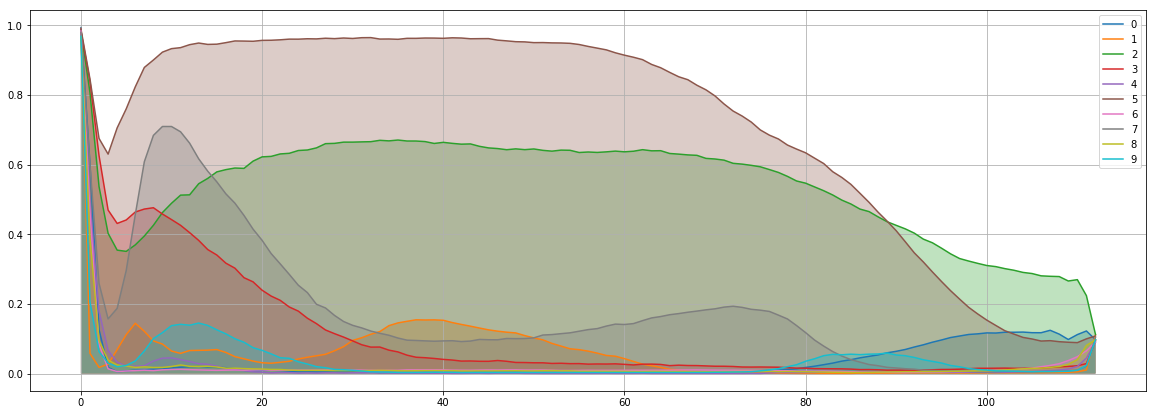

In [31]:
plt.figure(figsize=(20, 7))
for digit in range(10):
    print('{}: AUC={:.3f}, Area={:.3f}'.format(digit, auc(hist_sas_ft[:, np.argmax(y_test, 1) == digit].mean(1)),
                                               ((x_test[np.argmax(y_test, 1) == digit] - 0.8) * 5).mean()))
    plt.plot(hist_sas_ft[:, np.argmax(y_test, 1) == digit].mean(1))
    plt.fill_between(range(hist_selfsal.shape[0]), hist_sas_ft[:, np.argmax(y_test, 1) == digit].mean(1), alpha=0.3)

plt.grid(True)
plt.legend(range(10))
plt.show()

### Evaluation for individual digits (intensities)

0: AUC=0.025, Area=0.172
1: AUC=0.012, Area=0.077
2: AUC=0.733, Area=0.150
3: AUC=0.062, Area=0.143
4: AUC=0.033, Area=0.123
5: AUC=0.499, Area=0.132
6: AUC=0.032, Area=0.144
7: AUC=0.195, Area=0.115
8: AUC=0.022, Area=0.153
9: AUC=0.049, Area=0.125


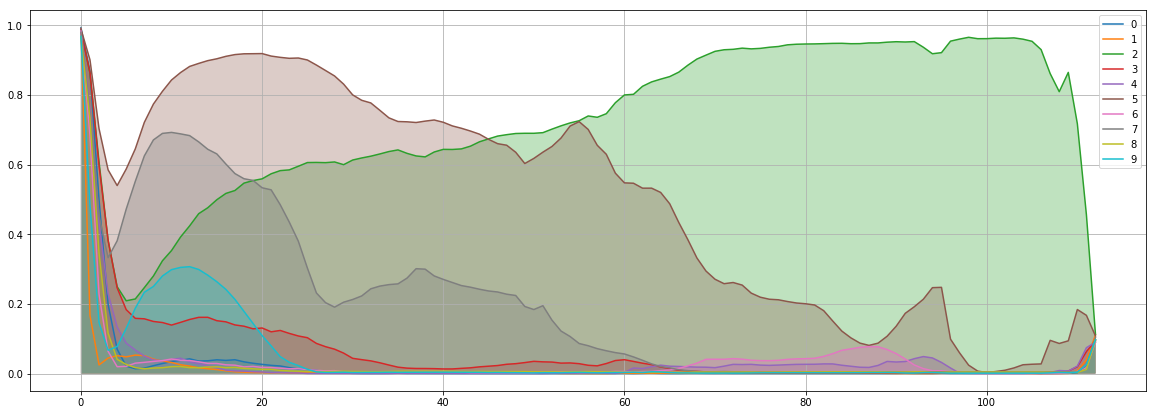

In [30]:
plt.figure(figsize=(20, 7))
for digit in range(10):
    print('{}: AUC={:.3f}, Area={:.3f}'.format(digit, auc(hist_selfsal[:, np.argmax(y_test, 1) == digit].mean(1)),
                                               ((x_test[np.argmax(y_test, 1) == digit] - 0.8) * 5).mean()))
    plt.plot(hist_selfsal[:, np.argmax(y_test, 1) == digit].mean(1))
    plt.fill_between(range(hist_selfsal.shape[0]), hist_selfsal[:, np.argmax(y_test, 1) == digit].mean(1), alpha=0.3)

plt.grid(True)
plt.legend(range(10))
plt.show()

### Step by step

In [23]:
def analyze(imgs, y, explanations, N, i):
    img_copy = imgs[i].copy().reshape(1, 28, 28, 1)
    predictions = model.predict(img_copy)[0]    
    top = np.argmax(predictions)
    n_steps = (28 * 28 + N - 1) // N
    hist = np.empty(n_steps + 1)
    hist[0] = predictions[top]    
    painting_order = np.flip(np.argsort(explanations[i].reshape(-1, 28*28), axis=1), axis=-1)    
    
    r = np.array(range(10000)).reshape(10000, 1)
    # While not all pixels are black
    for step in range(n_steps):
        if step % 8 == 0:
            print('Step {}/{}, P={}'.format(step, n_steps, hist[step]))
            plt.imshow(img_copy[0, :, :, 0], vmin=0, vmax=1)
            plt.show()
        coords = painting_order[:, N * step:N * (step + 1)]
        img_copy.reshape(1, -1)[0, coords] = 0
        hist[step + 1] = model.predict(img_copy)[0][top]
    print('Step {}/{}, P={}'.format(step, n_steps, hist[step]))
    plt.imshow(img_copy[0, :, :, 0], vmin=0, vmax=1)
    plt.show()
    return hist

Step 0/112, P=0.9923036098480225


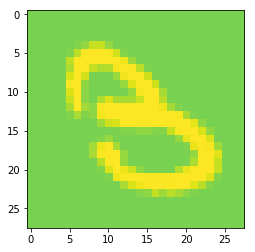

Step 8/112, P=0.2812579572200775


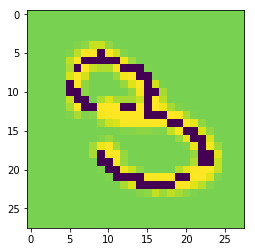

Step 16/112, P=0.004910967778414488


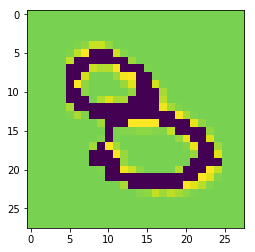

Step 24/112, P=0.016693193465471268


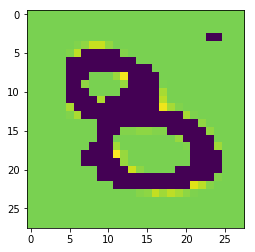

Step 32/112, P=0.006920570507645607


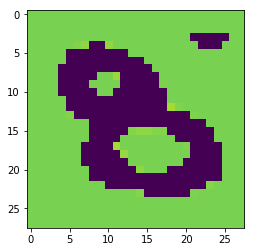

Step 40/112, P=0.24545572698116302


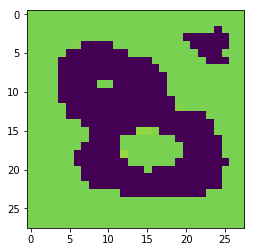

Step 48/112, P=0.9993450045585632


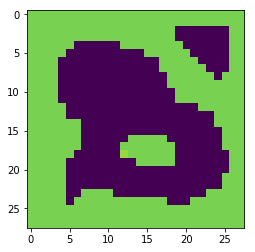

Step 56/112, P=0.9963247179985046


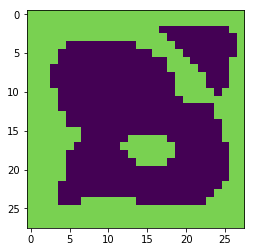

Step 64/112, P=0.9890844225883484


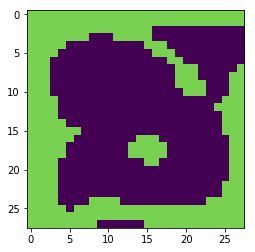

Step 72/112, P=0.04156646877527237


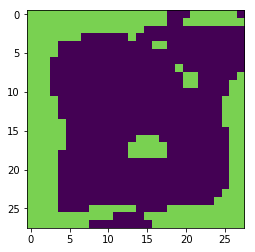

Step 80/112, P=0.006860009394586086


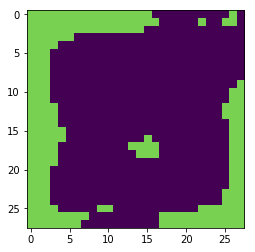

Step 88/112, P=0.033361416310071945


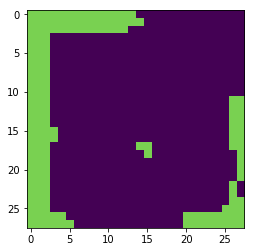

Step 96/112, P=0.1673816293478012


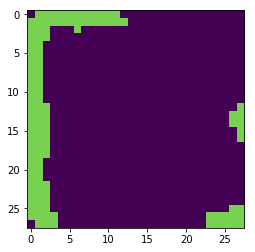

Step 104/112, P=0.2288709282875061


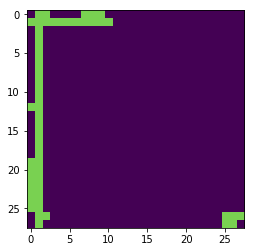

Step 111/112, P=0.10824483633041382


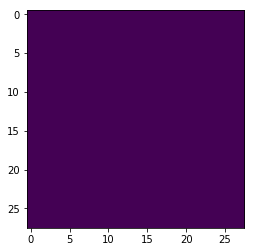

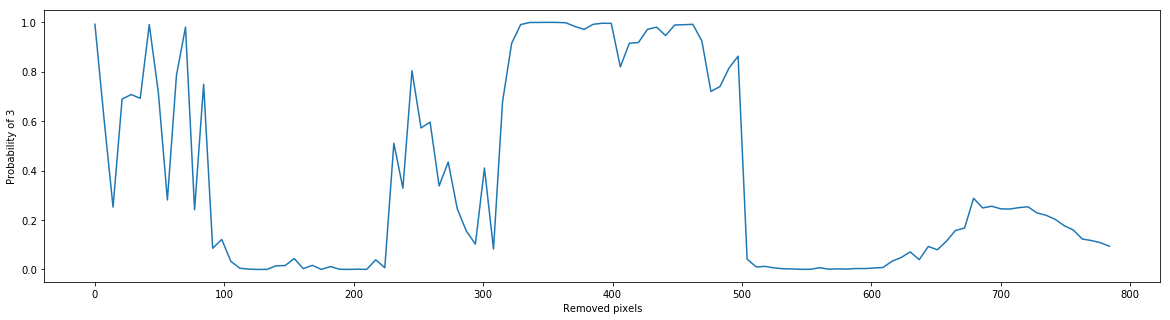

In [27]:
scores = analyze(x_test, y_test, sas_ft, N=7, i=18)
plt.figure(figsize=(20, 5))
plt.xlabel('Removed pixels')
plt.ylabel('Probability of 3')
plt.plot(7*np.arange(len(scores)), scores)
plt.show()